# Extract meniscus from Chronos capillary/property measurement data
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2025 Monash Univ.
    @license GPL-3.0+
    @version 0.0.1
    @date 23/06/2025

    Multiphase Flow Laboratory
    Monash University, Australia




In [1]:
import matplotlib.pyplot as plt
import sys, os, tqdm
import numpy as np
import scipy.ndimage as si
import tifffile
import h5py
%matplotlib widget

In [2]:
from pySciCam.pySciCam import ImageSequence # https://github.com/djorlando24/pySciCam

## Load raw images

In [3]:
path_to_raw='/Users/dduke/Desktop/e1234.raw'
I = ImageSequence(path_to_raw,rawtype='chronos14_mono_12bit',width=1280,height=512,frames=None)

Reading /Users/dduke/Desktop/e1234.raw
Chronos 12-bit RAW
File contains 3701 frames (1280 x 512)
Read 3469.0 MiB in 27.2 sec
	Data in memory:	 (3701, 512, 1280)
	Intensity range:	 0 to 849 	 uint16
	Array size:	4626.2 MB


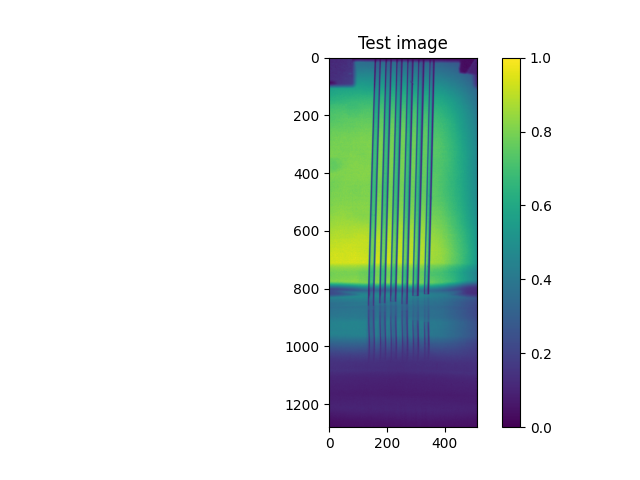

In [4]:
fig=plt.figure()

#frame=np.moveaxis(I.arr[-1,...],0,2).astype(np.float) # color
frame=I.arr[0,...].astype(float) # mono
plt.imshow(np.rot90(frame/np.nanmax(frame),3))
plt.colorbar()
plt.title("Test image");

## Background removal and cleanup

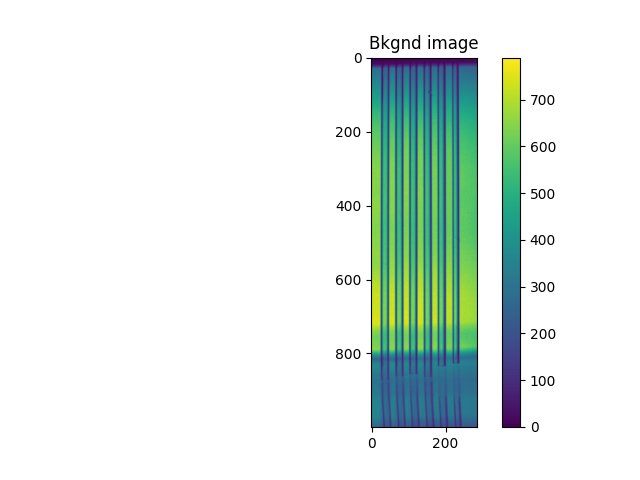

In [5]:
angle = 271.5
crop = (0,1000,130,-130)
bkgnd_frame = 100

# Use first image before liquid rises, as the reference
bk1 = I.arr[bkgnd_frame,...].astype(float) # mono
bk2 = si.rotate(bk1, angle) # rotate
bk = bk2[crop[0]:crop[1],crop[2]:crop[3]]

plt.close()
fig=plt.figure()
plt.imshow(bk)
plt.colorbar()
plt.title("Bkgnd image");

### Save TIFF of background for spatial res check

In [157]:
file_name = os.path.splitext(path_to_raw)[0]+'_bkgnd.tif'
tifffile.imwrite(file_name, bk.astype(np.uint16), imagej=True)

### Batch process background removal

In [6]:
# Make new array with this removed
Ib = np.zeros((I.N,*bk.shape), float)

for i in tqdm.tqdm(range(I.shape()[0])):
    tmp1=si.rotate(I.arr[i,...], angle) # rotate
    tmp2=tmp1[crop[0]:crop[1],crop[2]:crop[3]] # crop
    Ib[i,...]=tmp2/(bk+1) # remove bkgnd

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 3701/3701 [02:58<00:00, 20.76it/s]


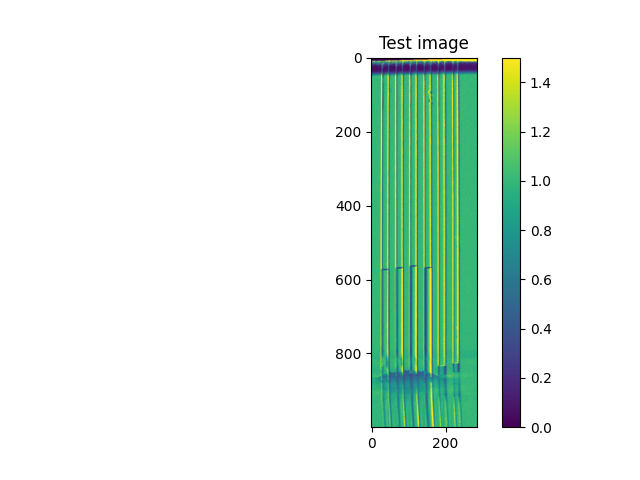

In [7]:
plt.close()
fig=plt.figure()
plt.imshow(Ib[-100,...],vmin=0,vmax=1.5)
plt.colorbar()
plt.title("Test image");

In [8]:
del I

## Find meniscus of liquid pool

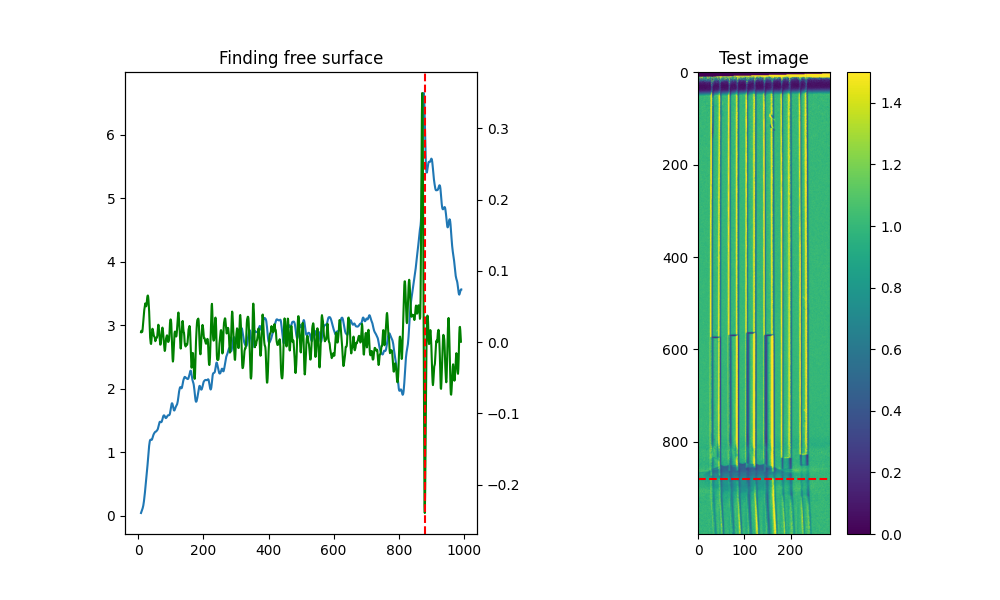

In [9]:
w = 8 # smoothing window width
z = np.nanmin(bk,axis=1) # horiz. minimum

####
y = range(bk.shape[0])
z = (z-np.nanmin(z))/(np.nanmax(z)-np.nanmin(z)) # normalize
z_sm = np.convolve(z,np.hanning(w*2),'valid') # smoothed
dz_sm = np.diff(z_sm) # gradient

i_surf = np.where(dz_sm==np.nanmin(dz_sm))[0][0]
y_surf = y[w+i_surf]

fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(121)
ax.plot(y[w:-w+1],z_sm);
ax=ax.twinx()
ax.plot(y[w:-w],dz_sm,c='g');
plt.axvline(y_surf,c='r',ls='--')
plt.title("Finding free surface");

ax=fig.add_subplot(122)
plt.imshow(Ib[-100,...],vmin=0,vmax=1.5)
plt.axhline(y_surf,c='r',ls='--')
plt.colorbar()
plt.title("Test image");

## Capillaries - find approximate positions

[37, 76, 113, 152, 190, 227]


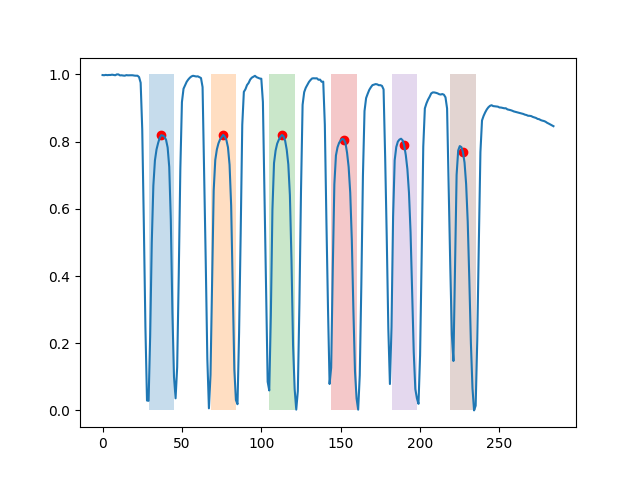

In [10]:
cap_avg_hw = 8 # halfwidth for averaging

# average slice horizontally
x=np.arange(bk.shape[1])
z = np.mean(bk,axis=0)
z = (z-np.nanmin(z))/(np.nanmax(z)-np.nanmin(z))

# find local minima
k=[]
for i in x[5:]:
    #if np.sign(z[i]-.5) != np.sign(z[i-1]-.5):
    if (z[i] == np.nanmin(z[i-5:i+4])) & (z[i]<.5):
        k.append(i)

# Estimate cap centers
k2=[]
for i in range(int(len(k)/2.)):
    k2.append(int((k[2*i]+k[2*i+1])/2.))

print(k2)

plt.close()
fig=plt.figure()
plt.plot(z);
for i in k2:
    plt.fill_between([i-cap_avg_hw, i+cap_avg_hw],[1, 1],alpha=.25)
plt.scatter(k2,z[k2],c='r');

## Capillaries - plot profiles

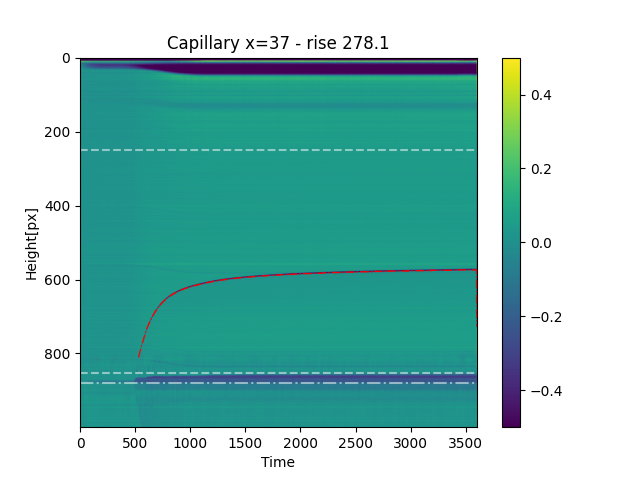

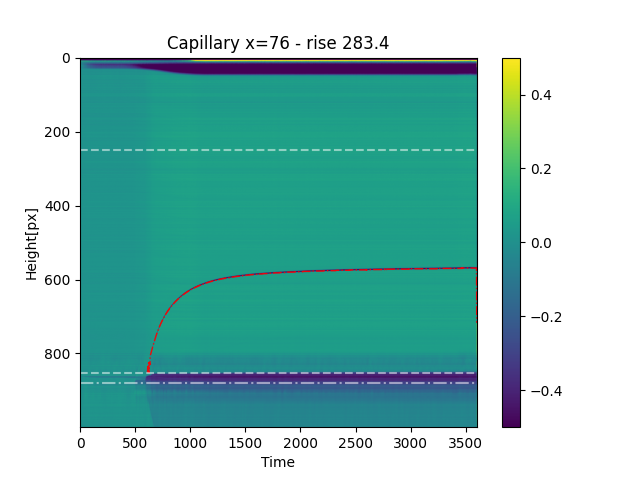

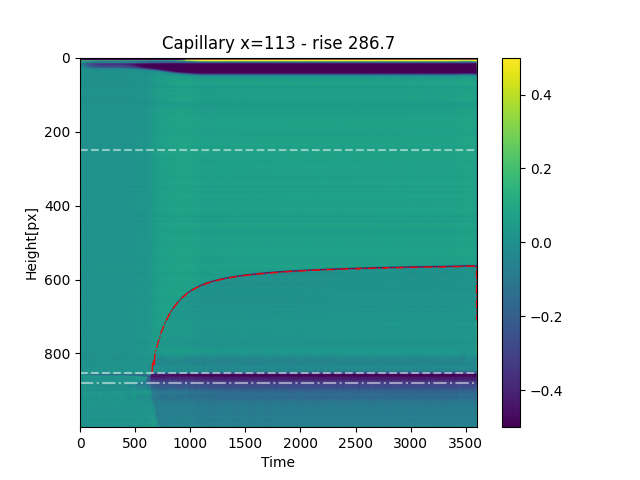

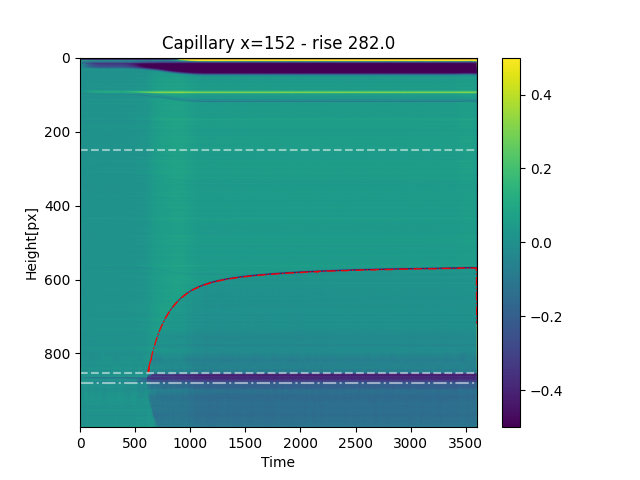

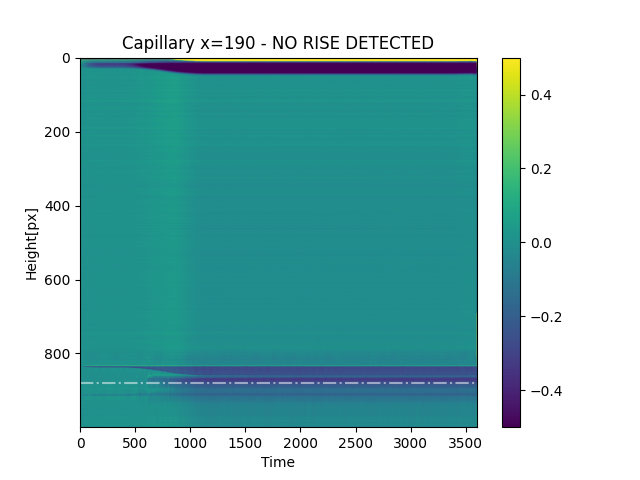

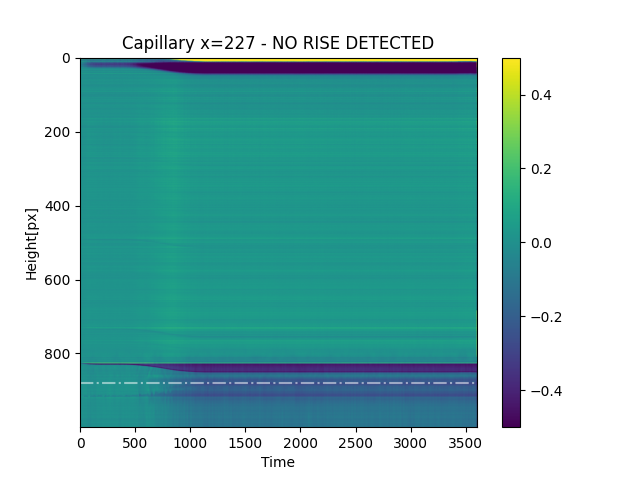

In [11]:
time_range=(100,-1)
vert_range=(250,y_surf-27) # below cap holder, above surface reflections
meniscus_threshold=-0.05 # how dark does the meniscus have to be to get detected wrt mean, should be just <0
max_dhdt = 20 # px difference per frame max. for outlier removal

meniscus_result = []
for i in k2: # for each cap.

    # Subset of data inside capillary
    Isub = Ib[time_range[0]:time_range[1],:,i-cap_avg_hw:i+cap_avg_hw]
    
    # horiz. avg across cap.
    spacetime = np.nanmean(Isub ,axis=2 )
        
    # remove mean and find meniscus if present
    h = np.zeros(spacetime.shape[0],)
    h[:] = np.nan
    
    for j in range(spacetime.shape[0]):
        spacetime[j,:] -= np.nanmean(spacetime[j,:]) # remove spatial average at each time
        s = spacetime[j,vert_range[0]:vert_range[-1]] # subset of data in good vertical range
        if np.nanmin(s)<meniscus_threshold: # min threshold for detection
            h[j] = np.where(s == np.nanmin(s))[0][0] + vert_range[0] # record height
            #if h[j] > y_surf: h[j]=np.nan  # below liquid surface doesnt count (reflection/error)

    # remove bad data points
    h = np.array(h)
    outlier = np.abs(np.diff(h))>max_dhdt
    outlier = np.hstack((0,outlier))
    h[outlier]=np.nan

    # check if the overall profile is acceptable, a rise occurred 
    m_rise = np.nanmean(y_surf - h)
    result='rise %.1f' % m_rise
    if m_rise > 50:
        meniscus_result.append(y_surf - h) # distance from the surface
    else:
        result='NO RISE DETECTED'
        meniscus_result.append(np.nan)
    
    fig=plt.figure()
    plt.imshow(spacetime.transpose(),vmin=-0.5,vmax=0.5,aspect='auto');
    if result!='NO RISE DETECTED':
        plt.plot(h,color='red',lw=1,ls='-.',alpha=.9)
        for v in vert_range: plt.axhline(v,ls='--',c='white',alpha=.5)
    plt.axhline(y_surf,ls='-.',c='white',alpha=.5)
    plt.colorbar()
    plt.title("Capillary x=%i - %s" % (i,result))
    plt.xlabel("Time")
    plt.ylabel("Height[px]")
    

### Save results for later analysis

In [14]:
spatialResolution = 0.047 # mm per pixel
timeResolution = 500 # frames/s

file_name = os.path.splitext(path_to_raw)[0]+'.h5'
H=h5py.File(file_name,'w')

for i in range(len(meniscus_result)):
    if meniscus_result[i] is not np.nan:
        time = np.arange(0,len(meniscus_result[i])/timeResolution,1./timeResolution)
        d = np.vstack((time, meniscus_result[i]*spatialResolution))
        D=H.create_dataset('capillary_%i' % k2[i], data=d, compression='gzip')
        D.attrs['start_frame']=time_range[0]
        D.attrs['mm_per_pixel']=spatialResolution
        D.attrs['frames_per_s']=timeResolution
        D.attrs['units']='seconds, mm'
H.close()